In [1]:
import numpy as np
from pymdp import utils, learning, maths
from pymdp.agent import Agent
import copy
import matplotlib.pyplot as plt
import itertools

DEDIFF_FACTOR = 0.1
CERTAIN_THRESHOLD = 0.9
MIN_STRESS = 0
MAX_STRESS = 50
SELF_STRESS_INCREMENT = 2
ALL_PENPAL_STRESS_INCREMENT = 0
STRESS_RELIEF = 0.2
B_MASS = 100000 # TODO: Why does this limit how undifferentiated cells can become?

Many thanks to the following for their helpful examples that I learned and borrowed from:
https://pymdp-rtd.readthedocs.io/en/latest/notebooks/active_inference_from_scratch.html#complete-recipe-for-active-inference
https://www.youtube.com/watch?v=uX8iSoDR83g
https://pymdp-rtd.readthedocs.io/en/latest/notebooks/using_the_agent_class.html

May this code serve the benefit of countless beings.

# The Connected Agent: An Active Inference agent with penpals

In [2]:
class ConnectedAgent(Agent):
    def __init__(self, penpals = [], is_seed_cell = False, stem_dim = 2, *args, **kwargs):
        self.is_seed_cell = is_seed_cell
        A = utils.initialize_empty_A([stem_dim], [stem_dim])
        A[0] = np.eye(stem_dim)
        # TODO: Should the original agent observing the environment have B 4x4x4 or 2x2x4 or something else?
        B = utils.obj_array(1)
        B[0] = np.full((stem_dim, stem_dim, stem_dim), 1.0 / stem_dim)
        pB = utils.dirichlet_like(B, scale = 0.1)
        C = utils.obj_array_zeros([stem_dim]) # This will update in update_B
        D = utils.obj_array_uniform([stem_dim]) # TODO: Add learning for D?
        super().__init__(A = A, B = B, pB = pB, lr_pB = 1.0, C = C, D = D,
                         action_selection = 'deterministic', save_belief_hist = True, *args, **kwargs)
        self.penpals = []
        self.action = np.array([0])
        [self.add_bilateral_penpal(p) for p in penpals]
        self.add_bilateral_penpal(self)
        self.stress = 0
        # TODO modify this so that it's actually helpful,
        # perhaps picking at random or [1] so agents don't inadvertently stop having kids:
    
    def __repr__(self):
        return f"CA{hex(id(self))[-4:]}"
    
    def stemness(self):
        max_possible_entry = 1.0 / len(self.B[0])
        min_actual_entry = np.min(self.B[0])
        return min_actual_entry / max_possible_entry
        
    def update_B(self):
        # Re-compute B first so I'm not using the binarized version from a previous turn:
        self.B = utils.norm_dist_obj_arr(self.pB)
        # TODO: Make this take effect in real-time, not a timestep later
        dim = len(self.pB[0][:,:,0])
        pB_average = np.average(self.pB[0])
        if self.stress > 0:
            self.pB[0] = (self.pB[0] * (100 - self.stress) + (pB_average * self.stress)) / 100 # Make it stemmier
            # TODO: Daphne suggests using softmax instead
            self.action_selection = 'deterministic'
        else:
            self.pB[0] -= pB_average * DEDIFF_FACTOR # TODO: Use a sharpen filter instead??
            self.action_selection = 'deterministic'
        cur_sum_pB = np.sum(self.pB[0])
        if cur_sum_pB >= B_MASS:
            target_sum_pB = B_MASS
            pB_reweight_coefficient = target_sum_pB / cur_sum_pB
            self.pB[0] *= pB_reweight_coefficient
            print(f"Mass of pB: {np.sum(self.pB[0])}")
        self.pB[0] = np.maximum(self.pB[0], np.full((dim, dim, dim), 0.05))
        if len(self.qs_hist) > 2:
            super().update_B(self.qs_hist[-2])
        if self.stress == 0:
            new_B = copy.deepcopy(self.B)
            dim = len(new_B[0])
            # TODO: consider npappply_over_axes to simplify other logic elsewhere
            def sample_f(col):
                if max(col) > CERTAIN_THRESHOLD:
                    return utils.onehot(np.argmax(col), dim)
                else:
                    return col
            new_B[0] = np.apply_along_axis(sample_f, 0, new_B[0])
            self.B = new_B
        # TODO: Should the sampling of the Dirichlet (using norm_dist_obj_arr) be stochastic rather than the EV?
        return self.pB
    
    def update_C(self):
        # Currently, I always align with my "parent," whether that's the env or an environment
        if self.is_seed_cell:
            parent_index = 0
        else:
            parent_index = 2

        for i in range(len(self.C[0])):
            if (i & 2 > 0) == (i & int(2 ** parent_index) > 0):
                self.C[0][i] = 1000
            else:
                self.C[0][i] = 0
        print(f"C: {self.C[0]}")
    
    def _interacts_with_environment(self):
        return any([isinstance(p, EnvironmentAgent) for p in self.penpals])
    
    # TODO: Figure out how to check if the penpals have already been added so I don't double-add them!
    def add_bilateral_penpal(self, p):
        if p in self.penpals:
            return # For now don't allow a penpal to be added more than once
        # TODO: Delete an old penpal if there are too many, or return True or False?
        for x, y in [[self, p], [p, self]]:
            x.penpals.append(y)
            x.A[0] = np.eye(len(x.A[0])*2)
            for tensor in [x.B, x.pB, x.C, x.D, x.qs]:
                for method in [np.hstack, np.vstack, np.dstack][:len(tensor[0].shape)]:
                    tensor[0] = method([tensor[0], tensor[0]])
            # TODO: Figure out why x.E doesn't work above
            # x.update_C(obs = None)
            x.E = np.hstack([x.E, x.E]) / 2
            x._update_nums()
            # Note there's no need to update self.action because the new penpal is always added on the end,
            # so if self.action was 3 with 2 penpals it'll still be 3 with 3 penpals
            if y == self: # If I'm connecting to myself, don't add another-nother penpal
                break
        
    def bilateral_disconnect_from(self, p):
        # TODO: Test the heck out of this
        for x, y in [[self, p], [p, self]]:
            s_index = x.penpals.index(y) + x._interacts_with_environment()
            dim = int(len(x.B[0][:,:,0]) / 2)
            indices = np.arange(dim * 2)
            and_arg = int(dim / (2 ** s_index))
            first_indices = indices[indices & and_arg == 0]
            second_indices = indices[indices & and_arg != 0]
            print(f"indices {indices}, and_arg {and_arg}, s_index {s_index}, dim {dim}")
            x.A[0] = np.eye(dim)
            for tensor in [x.B, x.pB, x.C, x.D, x.qs]:
                first_ix_in = [first_indices] * len(tensor[0].shape)
                second_ix_in = [second_indices] * len(tensor[0].shape)
                first_ix_specific = np.ix_(*first_ix_in)
                print(first_ix_specific)
                # e.g. if tensor shape is 2, first_ix_specific is [first_indices, first_indices]
                second_ix_specific = np.ix_(*second_ix_in)
                tensor[0] = tensor[0][first_ix_specific] + tensor[0][second_ix_specific]
                tensor /= (2 ** (len(tensor[0].shape) - 1)) # TODO: Should this occur for x.pB also?
            # TODO: Figure out why x.E doesn't work above
            # x.update_C(obs = None)
            # x.C[0][[0, -1]] = 100 # Agent prefers all bits to be the same
            x.E = sum(np.hsplit(x.E, 2)) / 2
            x._update_nums()
            cur_action = int(x.action[0])
            new_action = 0
            masks = x._bit_loc_masks('all')
            y_pos = x._bit_locs(y)[0]
            masks = np.delete(masks, y_pos)
            for i, mask in enumerate(masks):
                res = ((mask & cur_action > 0) << i)
                new_action += res
            x.action[0] = new_action
            x.penpals.remove(y)
            if y == self: # If I'm disconnecting from myself, don't do it again
                break
        # TODO: See what happens when disconnected cells remain connected to themselves; does it get cancer?
    
    def _update_nums(self):
        self.num_states = [self.B[f].shape[0] for f in range(len(self.B))]
        self.num_factors = len(self.num_states)
        self.num_controls = [self.B[f].shape[2] for f in range(self.num_factors)]
        self.policies = self._construct_policies()
    
    # TODO: Implement a max number of penpals per cell, and remove connections to make space for new ones?
    def asymmetric_divide(self):
        # TODO: If there's a maximum number of penpals per cell, delete the least efficacious channel
        # new_agent = ConnectedAgent(penpals = [self] + self.penpals)
        new_agent = ConnectedAgent(penpals = [self])
        print(f"New cell from asymmetric division: {new_agent}")
        return [self, new_agent]
    
    def symmetric_divide(self):
        # Copy over the old penpals:
        new_agent = ConnectedAgent(is_seed_cell = False, penpals = self.penpals)
        # Swap me to position 0 per usual convention:
        my_pos = new_agent.penpals.index(new_agent)
        new_agent.penpals[0], new_agent.penpals[my_pos] = new_agent.penpals[my_pos], new_agent.penpals[0]
        self.stress, new_agent.stress = self.stress / 2, self.stress / 2
        print(f"CHECKING {new_agent.penpals}, {self.penpals}")
        # Copy over my generative model:
        for nat, st in zip([new_agent.A, new_agent.B, new_agent.pB, new_agent.C, new_agent.D, new_agent.E, new_agent.qs, new_agent.action],
                           [self.A, self.B, self.pB, self.C, self.D, self.E, self.qs, self.action]):
            nat[0] = copy.copy(st[0])
        print(f"New cell from symmetric division: {new_agent}")
        return [self, new_agent]
    
    def wants_to_divide(self):
        return True
    
    # Convention if the cell interacts with the environment:
    # Message: 1   0   0
    #          ^   ^   ^
    # Meaning: p1  p0  env
    
    # wrt can be:
    # * 'env': my message for the environment
    # * a penpal
    # * an index, representing the index of a penpal
    # TODO: Get rid of 'env' altogether; just have an environment agent which is a subclass of ConnectedAgent?
    
    def message_for(self, wrt = 'env'):
        return int(self.action[0]) & self._bit_loc_masks(wrt)[0] > 0
    
    # Same input types as above: this one mainly for debugging to make sure messages are received intact
    def message_from(self, a_in, wrt = 'env'):
        return a_in & self._bit_loc_masks(wrt)[0] > 0
    
    def self_efficacy(self, wrt = None):
        # TODO: Consider a self-efficacy metric w.r.t. a given penpal which considers only how my actions
        # change the response from that particular penpal--especially relevant if I've collapsed outputs
        masks = self._bit_loc_masks(wrt)
        dim = self.B[0].shape[-1]
        slice_indices = np.arange(dim)
        results = []
        for m in masks: # Sean asks if I should share my stress most with the agents with whom I have highest/lowest self-efficacy?
            first_indices = np.nonzero(slice_indices & m == 0)
            second_indices = np.nonzero(slice_indices & m != 0)
            first_slices = self.B[0][:,:,first_indices]
            second_slices = self.B[0][:,:,second_indices]
            mean_abs_dif = np.mean(np.abs(first_slices - second_slices) * (dim / 2))
            results.append(mean_abs_dif)
        if hasattr(wrt, '__iter__') or isinstance(wrt, str):
            return np.array(results)
        else:
            return np.sum(results)
        # Should there be a self-efficacy that is independent of the size of B so it doesn't shrink/grow by a factor of 8 when penpals are added/removed?
    
    # wrt can be:
    # * 'env': just the index of the environment bit
    # * a penpal
    # * a list of penpals
    # * an index, representing the index of a penpal
    # * a list of indices, representing the indices of penpals
    # * 'all', meaning the indices of everything that exists among env, penpals
    # * None, which is like all but returns the average instead of a list
    def _bit_locs(self, wrt = None):
        if hasattr(wrt, '__iter__') and not isinstance(wrt, str):
            iterable_wrt = wrt
        else:
            iterable_wrt = [wrt]
        indices = []
        for w in iterable_wrt:
            if w == 'env':
                env_i = [i for i in range(len(self.penpals)) if isinstance(self.penpals[i], EnvironmentAgent)][0]
                indices.append(env_i)
            elif isinstance(w, int): # By convention, an integer w means the penpal of index w
                indices.append(w)
            elif isinstance(w, ConnectedAgent):
                indices.append(self.penpals.index(w))
            else: # Meaning w == None or w == 'all':
                indices = range(len(self.penpals))
                break # If any w in wrt is None or 'all', we include all indices always
        return np.array(indices).astype(int)
    
    def _bit_loc_masks(self, wrt = None):
        bit_locs = self._bit_locs(wrt)
        dim = self.B[0].shape[-1] # Assumes the B tensor is a cube
        return np.array([1 << b for b in bit_locs]).astype(int)
    
    def compute_input(self):
        tmp = 0
        for p in self.penpals:
            tmp += (p.message_for(self) * self._bit_loc_masks(p)[0])
        return tmp

# The Environment: What the collective interacts with

In [3]:
class EnvironmentAgent(ConnectedAgent):
    # TODO: Can improve performance by preventing infer_policies, etc.
    def __init__(self, fn, penpals = [], *args, **kwargs):
        super().__init__(penpals = penpals, *args, **kwargs)
        self.init_state = fn(0, -1)
        self.fn = fn
        self.curr_timestep = 0
        
    def __repr__(self):
        return 'env'
    
    def update_B(self):
        return
    
    def stemness(self):
        return 0
    
    def sample_action(self):
        act = self.fn(0, self.curr_timestep) # TODO: Allow the Env to take inputs from other cells!
        act_for_all = sum(act * self._bit_loc_masks('all')) # Put the act bit in each position
        self.action = np.array([act_for_all])
        self.step_time()
        print(f"Action: {act}, act_for_all: {act_for_all}")
        self.stress = 0 # This ensures the environment doesn't become a source of stress for other cells; could be interesting to experiment with this
        return act
    
    def max_cells(self, t): # TODO: Prioritize cell division if multiple cells want to divide on the same turn but we don't have space for all of them
        return 3

# Create the Seed Stem Cell




t = 0
num_agents 2
env IWE True, dim 8, self-efficacy 0.0, input 0
Self-efficacy in each channel [0. 0.]
Agent stress: 0
Action: True, act_for_all: 3
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000.]
env Received input: 0
	env->False->env
	CA0e80->False->env
env Sent output: 3
	env->True->env
	env->True->CA0e80


CHECKING [CA38b0, CA0e80, env], [env, CA0e80, CA38b0]
New cell from symmetric division: CA38b0
CA0e80 IWE True, dim 16, self-efficacy 0.0, input 0
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 0
	env->False->CA0e80
	CA0e80->False->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 0
	CA0e80->False->env
	CA0e80->False->CA0e80
	CA0e80->False->CA38b0





t = 1
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.

	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 1
	CA0e80->True->env
	CA0e80->False->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.06824532109426415, input 4
Self-efficacy in each channel [0.02113302 0.0182337  0.0288786 ]
Agent stress: 6.600231091985449
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 4
	CA38b0->False->CA38b0
	CA0e80->False->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 0
	CA38b0->False->CA38b0
	CA38b0->False->CA0e80
	CA38b0->False->env





t = 20
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 3
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 3
	env->True->env
	CA0e80->True->env
	CA38b0->False->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env

	CA38b0->False->CA38b0
	CA0e80->False->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 0
	CA38b0->False->CA38b0
	CA38b0->False->CA0e80
	CA38b0->False->env





t = 39
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 0
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 0
	env->False->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.10878137192974816, input 0
Self-efficacy in each channel [0.03470341 0.03521904 0.03885893]
Agent stress: 4.263724167746654
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 0
	env->False->CA0e80
	CA0e80->False->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 2
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80

Agent stress: 2.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 5
	env->True->env
	CA0e80->False->env
	CA38b0->True->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.11137766172597229, input 3
Self-efficacy in each channel [0.03398105 0.03649977 0.04089684]
Agent stress: 2.0981377326496746
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 3
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 1
	CA0e80->True->env
	CA0e80->False->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.09594145832220471, input 5
Self-efficacy in each channel [0.03753967 0.02637901 0.03202278]
Agent stress: 6.721291357480413
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0.

	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 2
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.09067740814975313, input 5
Self-efficacy in each channel [0.0333306  0.02687549 0.03047131]
Agent stress: 7.377048890397952
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 5
	CA38b0->True->CA38b0
	CA0e80->False->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 7
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->True->env





t = 78
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 4
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 4
	env->False->env
	CA0e80->False->env
	CA38b0->True->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True-

Self-efficacy in each channel [0.04288533 0.03434704 0.03876756]
Agent stress: 3.888313749555966
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 1
	CA38b0->True->CA38b0
	CA0e80->False->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 9
	CA38b0->True->CA38b0
	CA38b0->False->CA0e80
	CA38b0->False->env





t = 97
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 1
	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.14822223329010764, input 3
Self-efficacy in each channel [0.04626932 0.0511104  0.05084252]
Agent stress: 2.4595370954180718
C: [1000.    0.    0. 1000. 1000.    0.  

	env->True->env
	CA0e80->False->env
	CA38b0->True->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->False->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.1391973158265455, input 7
Self-efficacy in each channel [0.04327725 0.04823521 0.04768485]
Agent stress: 2.602138404189617
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 2
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.10243188337754795, input 5
Self-efficacy in each channel [0.04245989 0.0269269  0.03304509]
Agent stress: 6.911933910097783
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 5
	CA38b0->True->CA38b0
	CA0e80->False->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 3
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	C

	env->False->env
	CA0e80->True->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.15224058629883924, input 4
Self-efficacy in each channel [0.05017482 0.05566111 0.04640466]
Agent stress: 3.5395160260205483
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 4
	env->False->CA0e80
	CA0e80->False->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 2
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.11254987983252034, input 1
Self-efficacy in each channel [0.04193073 0.03432098 0.03629817]
Agent stress: 5.651498722149949
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 1
	CA38b0->True->CA38b0
	CA0e80->False->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 7
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80

	CA38b0->False->CA38b0
	CA0e80->False->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 2
	CA38b0->False->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 155
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 1
	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->False->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.16445322823201278, input 7
Self-efficacy in each channel [0.05138989 0.05975838 0.05330497]
Agent stress: 0.8695600944419608
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 9
	CA0e80->True->env
	CA0e80->False->CA0e80
	CA0e8

C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 4
	env->False->CA0e80
	CA0e80->False->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 2
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.11107980591794328, input 1
Self-efficacy in each channel [0.04223526 0.03154766 0.03729689]
Agent stress: 5.156867946646703
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 1
	CA38b0->True->CA38b0
	CA0e80->False->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 15
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->True->env





t = 175
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 5
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Receive

	CA38b0->True->CA38b0
	CA0e80->False->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 3
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 194
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 1
	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->False->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.15690339460464736, input 7
Self-efficacy in each channel [0.04840006 0.05788203 0.0506213 ]
Agent stress: 2.2089243471734155
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 14
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80

	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 9
	CA0e80->True->env
	CA0e80->False->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.104872583164835, input 4
Self-efficacy in each channel [0.03861684 0.03237562 0.03388013]
Agent stress: 5.462380403192817
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 4
	CA38b0->False->CA38b0
	CA0e80->False->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 2
	CA38b0->False->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 214
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 3
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 3
	env->True->env
	CA0e80->True->env
	CA38b0->False->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->F

C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 1
	CA38b0->True->CA38b0
	CA0e80->False->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 9
	CA38b0->True->CA38b0
	CA38b0->False->CA0e80
	CA38b0->False->env





t = 233
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 1
	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.12310943070202515, input 3
Self-efficacy in each channel [0.03783647 0.04493033 0.04034264]
Agent stress: 4.548965968511866
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 3
	env->True-

CA0e80 IWE True, dim 16, self-efficacy 0.12633075438263552, input 2
Self-efficacy in each channel [0.03894263 0.04562448 0.04176364]
Agent stress: 4.56292354781002
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 2
	env->False->CA0e80
	CA0e80->True->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 2
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.12674766963364406, input 0
Self-efficacy in each channel [0.04358971 0.03844564 0.04471232]
Agent stress: 3.6425661793041773
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 0
	CA38b0->False->CA38b0
	CA0e80->False->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 9
	CA38b0->True->CA38b0
	CA38b0->False->CA0e80
	CA38b0->False->env





t = 253
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 

Agent stress: 2.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 2
	env->False->env
	CA0e80->True->env
	CA38b0->False->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->False->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.10105605131499901, input 4
Self-efficacy in each channel [0.02775721 0.03812762 0.03517122]
Agent stress: 4.8065025723265205
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 4
	env->False->CA0e80
	CA0e80->False->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 0
	CA0e80->False->env
	CA0e80->False->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.10976585756015836, input 1
Self-efficacy in each channel [0.03788351 0.03027241 0.04160993]
Agent stress: 4.829267621819563
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0

Agent stress: 3.435295476613229
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 5
	env->True->CA0e80
	CA0e80->False->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 1
	CA0e80->True->env
	CA0e80->False->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.0919169295364701, input 5
Self-efficacy in each channel [0.03052581 0.02799867 0.03339245]
Agent stress: 6.096857965024154
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 5
	CA38b0->True->CA38b0
	CA0e80->False->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 3
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 291
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 2
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0. 

C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 5
	CA38b0->True->CA38b0
	CA0e80->False->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 7
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->True->env





t = 310
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 5
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 5
	env->True->env
	CA0e80->False->env
	CA38b0->True->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->False->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.12569696526628726, input 7
Self-efficacy in each channel [0.03788718 0.04325068 0.04455911]
Agent stress: 5.069799610042367
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True-

Agent stress: 3.8320279596718607
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 3
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 6
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.09966544078972348, input 4
Self-efficacy in each channel [0.03708611 0.03346108 0.02911825]
Agent stress: 5.62370663091808
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 4
	CA38b0->False->CA38b0
	CA0e80->False->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 2
	CA38b0->False->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 330
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0

	CA38b0->True->CA38b0
	CA0e80->False->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 0
	CA38b0->False->CA38b0
	CA38b0->False->CA0e80
	CA38b0->False->env





t = 349
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 1
	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.0996876617027885, input 1
Self-efficacy in each channel [0.0327764  0.03367539 0.03323586]
Agent stress: 5.925362963860653
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 1
	env->True->CA0e80
	CA0e80->False->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 6
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->

env IWE True, dim 16, self-efficacy 0.0, input 3
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 3
	env->True->env
	CA0e80->True->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.10352050440652567, input 3
Self-efficacy in each channel [0.03277862 0.03680483 0.03393706]
Agent stress: 4.4228747838363605
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 3
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 6
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.11888437608905009, input 7
Self-efficacy in each channel [0.04153662 0.03803016 0.03931759]
Agent stress: 2.706247434716895

	env->False->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.09591062778976743, input 2
Self-efficacy in each channel [0.03228191 0.03216292 0.03146579]
Agent stress: 5.048255789541955
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 2
	env->False->CA0e80
	CA0e80->True->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 12
	CA0e80->False->env
	CA0e80->False->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.10825739304767427, input 3
Self-efficacy in each channel [0.03604086 0.03673429 0.03548225]
Agent stress: 5.908659855686505
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 3
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 13
	CA38b0->True->CA38b0
	CA38b0->False->CA0e

C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 7
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 13
	CA38b0->True->CA38b0
	CA38b0->False->CA0e80
	CA38b0->True->env





t = 408
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 7
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: 1, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 7
	env->True->env
	CA0e80->True->env
	CA38b0->True->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.09338824515050226, input 1
Self-efficacy in each channel [0.02894033 0.03243551 0.03201241]
Agent stress: 6.361499282034173
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 1
	env->True->CA0e80

C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 14
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.0870470954294799, input 7
Self-efficacy in each channel [0.03118561 0.02836177 0.02749972]
Agent stress: 0.7592008382939576
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 7
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 6
	CA38b0->False->CA38b0
	CA38b0->True->CA0e80
	CA38b0->True->env





t = 428
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 5
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: 1, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input

Self-efficacy in each channel [0.0337639  0.03100336 0.03014976]
Agent stress: 0.0087529897278465
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 7
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 6
	CA38b0->False->CA38b0
	CA38b0->True->CA0e80
	CA38b0->True->env





t = 448
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 5
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: 1, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 5
	env->True->env
	CA0e80->False->env
	CA38b0->True->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.11991802837224928, input 7
Self-efficacy in each channel [0.03782015 0.04030909 0.04178879]
Agent stress: 0.005921142455154617
C: [1000.    0.    0. 1000. 1000.    0.    0

	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.12060816601141719, input 7
Self-efficacy in each channel [0.03805075 0.04053894 0.04201848]
Agent stress: 8.533265585485431e-05
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 14
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.0973820474603279, input 7
Self-efficacy in each channel [0.03458504 0.03182525 0.03097175]
Agent stress: 0.00010091510086837071
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 7
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 6
	CA38b0->False->CA38b0
	CA38b0->True->CA

Agent stress: 0.0
Action: 1, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 1
	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.12092635155085195, input 7
Self-efficacy in each channel [0.03815682 0.040645   0.04212453]
Agent stress: 9.838185398027702e-07
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 14
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.09850763147155875, input 7
Self-efficacy in each channel [0.03496023 0.03220045 0.03134695]
Agent stress: 1.1634718993071377e-06
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0. 

Agent stress: 1.676739715896216e-08
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 6
	CA38b0->False->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 507
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: 1, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 1
	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.1210998701241297, input 7
Self-efficacy in each channel [0.03821466 0.04070284 0.04218237]
Agent stress: 1.1342655511695221e-08
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]


	env->True->env
	CA0e80->False->env
	CA38b0->True->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.1212045630125807, input 7
Self-efficacy in each channel [0.03824955 0.04073774 0.04221727]
Agent stress: 1.6346489323476021e-10
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 14
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.09954701391614729, input 6
Self-efficacy in each channel [0.03530669 0.03254691 0.03169341]
Agent stress: 1.9331492760851245e-10
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 6
	CA38b0->False->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->C

	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 6
	CA38b0->False->CA38b0
	CA38b0->True->CA0e80
	CA38b0->True->env





t = 546
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 5
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: 1, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 5
	env->True->env
	CA0e80->False->env
	CA38b0->True->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.12128089142581715, input 7
Self-efficacy in each channel [0.038275   0.04076318 0.04224271]
Agent stress: 1.8846219065861756e-12
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 14
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->Tru

C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 6
	CA38b0->False->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 565
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: 1, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 1
	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.12133401745903626, input 7
Self-efficacy in each channel [0.0382927  0.04078089 0.04226042]
Agent stress: 2.7160264051954503e-14
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True

	CA38b0->False->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 585
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: 1, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 1
	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.12137679153126996, input 7
Self-efficacy in each channel [0.03830696 0.04079515 0.04227468]
Agent stress: 3.1313652496298687e-16
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 14
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->

C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 3
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 13
	CA38b0->True->CA38b0
	CA38b0->False->CA0e80
	CA38b0->True->env





t = 604
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 4
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 4
	env->False->env
	CA0e80->False->env
	CA38b0->True->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.11954188262569128, input 2
Self-efficacy in each channel [0.0377416  0.04016749 0.0416328 ]
Agent stress: 3.6
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 2
	env->False->CA0e80
	CA0e8

Agent stress: 5.2750164806991044
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 6
	env->False->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 8
	CA0e80->False->env
	CA0e80->False->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.1125265741681528, input 3
Self-efficacy in each channel [0.0384164  0.03679981 0.03731037]
Agent stress: 5.317378464694059
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 3
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 5
	CA38b0->True->CA38b0
	CA38b0->False->CA0e80
	CA38b0->True->env





t = 624
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 4
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.

	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 6
	CA38b0->False->CA38b0
	CA38b0->True->CA0e80
	CA38b0->True->env





t = 643
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 4
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 4
	env->False->env
	CA0e80->False->env
	CA38b0->True->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->False->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.08925745470789201, input 6
Self-efficacy in each channel [0.02881804 0.03014661 0.0302928 ]
Agent stress: 4.236292363213748
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 6
	env->False->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 8
	CA0e80->False->env
	CA0e80->False->CA0e80
	CA0e80-

	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 6
	CA38b0->False->CA38b0
	CA38b0->True->CA0e80
	CA38b0->True->env





t = 663
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 4
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 4
	env->False->env
	CA0e80->False->env
	CA38b0->True->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->False->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.07812714609339155, input 6
Self-efficacy in each channel [0.02549137 0.02624821 0.02638757]
Agent stress: 3.3973193944676403
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 6
	env->False->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 8
	CA0e80->False->env
	CA0e80->False->CA0e80
	CA0e80

C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 14
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.08797753505549841, input 7
Self-efficacy in each channel [0.02957373 0.02926182 0.02914198]
Agent stress: 3.334421041021227
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 7
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 683
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 0
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received 

C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 6
	CA38b0->False->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 702
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 1
	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->False->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.06559307801072693, input 7
Self-efficacy in each channel [0.02170347 0.02192364 0.02196597]
Agent stress: 2.232360186130657
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->Tr

	env->True->env
	CA0e80->True->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.06498798989838059, input 7
Self-efficacy in each channel [0.01900758 0.02367796 0.02230245]
Agent stress: 2.8805085604646083
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 0
	CA0e80->False->env
	CA0e80->False->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.0825771015680136, input 6
Self-efficacy in each channel [0.02823079 0.02631507 0.02803124]
Agent stress: 2.8211718613266763
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 6
	CA38b0->False->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	

	env->False->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 10
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.06186729883782785, input 1
Self-efficacy in each channel [0.02086104 0.02019657 0.02080968]
Agent stress: 5.136131824965692
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 1
	CA38b0->True->CA38b0
	CA0e80->False->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 15
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->True->env





t = 741
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 5
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 5
	env->True->env
	CA0e80->False->env
	CA38b0->True->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->T

	env->False->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.06617434593065277, input 4
Self-efficacy in each channel [0.01850346 0.02374356 0.02392733]
Agent stress: 4.481945840778432
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 4
	env->False->CA0e80
	CA0e80->False->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 14
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.07641456954486832, input 2
Self-efficacy in each channel [0.02513666 0.02506007 0.02621784]
Agent stress: 4.129153238966786
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 2
	CA38b0->False->CA38b0
	CA0e80->True->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 5
	CA38b0->True->CA38b0
	CA38b0->False->CA0e8

	env->False->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 12
	CA0e80->False->env
	CA0e80->False->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.06841562909111067, input 3
Self-efficacy in each channel [0.02228564 0.02292867 0.02320132]
Agent stress: 4.912554454245875
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 3
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 780
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 0
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 0
	env->False->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env-

C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 4
	CA38b0->False->CA38b0
	CA0e80->False->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 6
	CA38b0->False->CA38b0
	CA38b0->True->CA0e80
	CA38b0->True->env





t = 799
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 6
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 6
	env->False->env
	CA0e80->True->env
	CA38b0->True->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->False->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.07477292639022667, input 6
Self-efficacy in each channel [0.02354118 0.02595808 0.02527366]
Agent stress: 6.930065993392022
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 6
	env->Fal

CA0e80 IWE True, dim 16, self-efficacy 0.08750994724623977, input 3
Self-efficacy in each channel [0.02696022 0.029645   0.03090472]
Agent stress: 0.5567885772192426
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 3
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 13
	CA0e80->True->env
	CA0e80->False->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.06629729957059197, input 7
Self-efficacy in each channel [0.02137043 0.02278241 0.02214445]
Agent stress: 2.73536620821284
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 7
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 5
	CA38b0->True->CA38b0
	CA38b0->False->CA0e80
	CA38b0->True->env





t = 819
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 6
Self-efficacy in each channel [0. 0. 0.

C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 3
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 838
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 1
	env->True->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.09240874417151256, input 7
Self-efficacy in each channel [0.02876242 0.03143023 0.03221609]
Agent stress: 1.1449631560419558
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True-

	env->True->env
	CA0e80->True->env
	CA38b0->False->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->False->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.09170368293262987, input 7
Self-efficacy in each channel [0.02837348 0.03090092 0.03242928]
Agent stress: 3.075475378057291
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 7
	CA0e80->True->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.07234600516181038, input 7
Self-efficacy in each channel [0.02538226 0.02356214 0.0234016 ]
Agent stress: 1.8720932011607911
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 7
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	C

	env->False->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 15
	CA0e80->True->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.062007899549070225, input 3
Self-efficacy in each channel [0.02141912 0.02033853 0.02025025]
Agent stress: 4.08753965704671
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 3
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 877
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 3
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 2.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 3
	env->True->env
	CA0e80->True->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->Tru

	env->True->env
	CA0e80->True->env
	CA38b0->True->env
env Sent output: 0
	env->False->env
	env->False->CA0e80
	env->False->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.08196792240349163, input 1
Self-efficacy in each channel [0.02630344 0.02751668 0.02814781]
Agent stress: 3.20876502334732
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 1
	env->True->CA0e80
	CA0e80->False->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 12
	CA0e80->False->env
	CA0e80->False->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.0754427269478891, input 6
Self-efficacy in each channel [0.02445376 0.02427814 0.02671083]
Agent stress: 2.6228260620512103
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 6
	CA38b0->False->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 1
	CA38b0->True->CA38b0
	CA38b0->False->CA0e80

Agent stress: 1.2848735774830933
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 0
	env->False->CA0e80
	CA0e80->False->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 6
	CA0e80->False->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.0717267648079838, input 3
Self-efficacy in each channel [0.02540975 0.02252324 0.02379377]
Agent stress: 4.098358857790906
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 3
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->False->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 916
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 1
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0

C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 7
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->True->CA0e80
CA0e80 Sent output: 7
	CA0e80->True->env
	CA0e80->True->CA0e80
	CA0e80->True->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.060583554344551045, input 7
Self-efficacy in each channel [0.02348137 0.01858218 0.01852001]
Agent stress: 3.2786884986790206
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 7
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 4
	CA38b0->False->CA38b0
	CA38b0->False->CA0e80
	CA38b0->True->env





t = 935
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 7
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: False, act_for_all: 0
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received 

C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 6
	CA38b0->False->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 4
	CA38b0->False->CA38b0
	CA38b0->False->CA0e80
	CA38b0->True->env





t = 954
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 6
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 6
	env->False->env
	CA0e80->True->env
	CA38b0->True->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.0857073936259854, input 2
Self-efficacy in each channel [0.02792888 0.02839695 0.02938157]
Agent stress: 3.8948217962436535
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 2
	env->False->

	env->True->env
	CA0e80->True->env
	CA38b0->True->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.08858919125744802, input 3
Self-efficacy in each channel [0.02899006 0.03014287 0.02945626]
Agent stress: 3.027709305682465
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 3
	env->True->CA0e80
	CA0e80->True->CA0e80
	CA38b0->False->CA0e80
CA0e80 Sent output: 1
	CA0e80->True->env
	CA0e80->False->CA0e80
	CA0e80->False->CA38b0


CA38b0 IWE True, dim 16, self-efficacy 0.061425422615570914, input 7
Self-efficacy in each channel [0.02352952 0.01919007 0.01870583]
Agent stress: 3.2949014832443937
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 7
	CA38b0->True->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 4
	CA38b0->False->CA38b0
	CA38b0->False->CA0e80
	

C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
CA38b0 Received input: 6
	CA38b0->False->CA38b0
	CA0e80->True->CA38b0
	env->True->CA38b0
CA38b0 Sent output: 11
	CA38b0->True->CA38b0
	CA38b0->True->CA0e80
	CA38b0->False->env





t = 993
num_agents 3
env IWE True, dim 16, self-efficacy 0.0, input 0
Self-efficacy in each channel [0. 0. 0.]
Agent stress: 0.0
Action: True, act_for_all: 7
C: [1000. 1000.    0.    0.    0.    0. 1000. 1000. 1000. 1000.    0.    0.
    0.    0. 1000. 1000.]
env Received input: 0
	env->False->env
	CA0e80->False->env
	CA38b0->False->env
env Sent output: 7
	env->True->env
	env->True->CA0e80
	env->True->CA38b0


CA0e80 IWE True, dim 16, self-efficacy 0.08075356072060014, input 4
Self-efficacy in each channel [0.02477903 0.0300254  0.02594913]
Agent stress: 2.917611763417099
C: [1000.    0.    0. 1000. 1000.    0.    0. 1000. 1000.    0.    0. 1000.
 1000.    0.    0. 1000.]
CA0e80 Received input: 4
	env->False

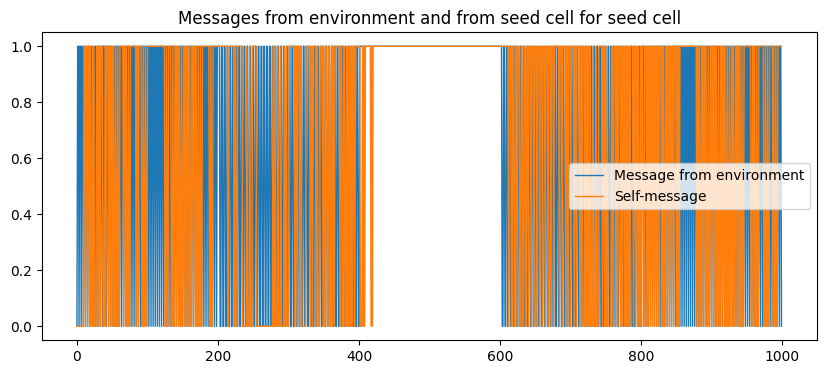

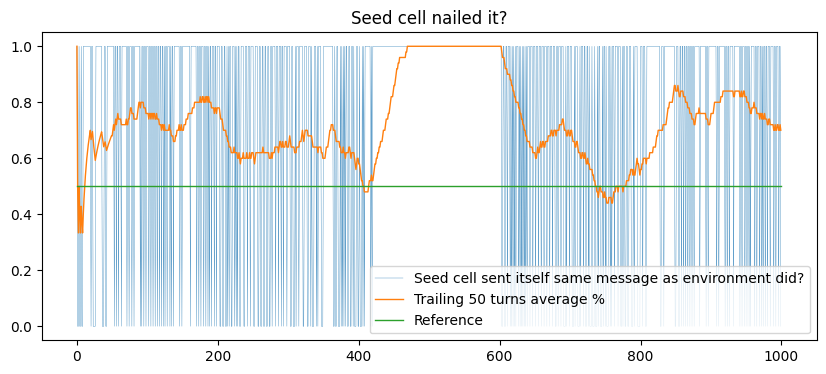

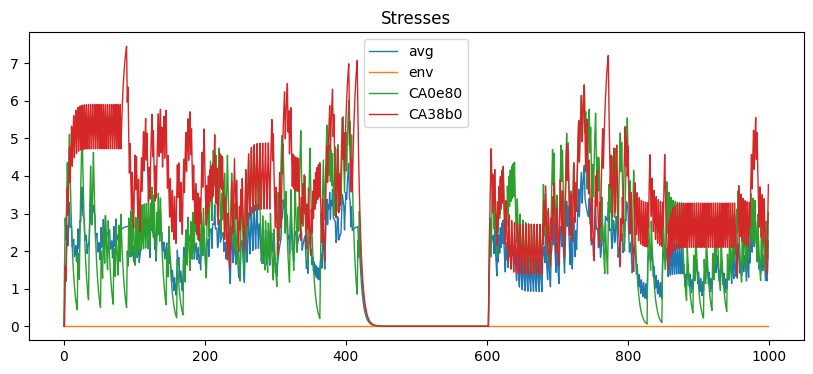

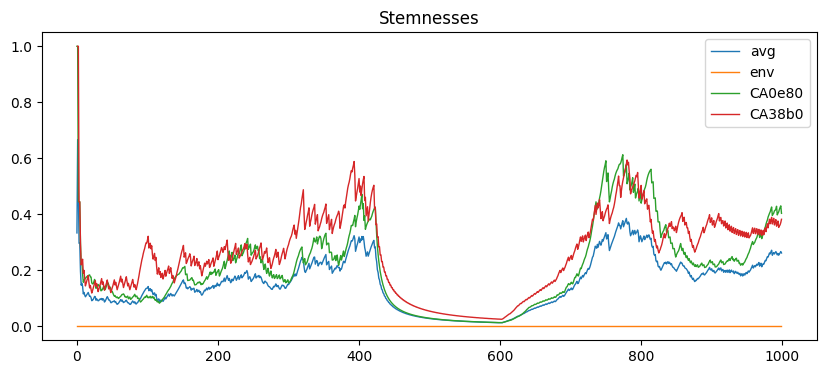

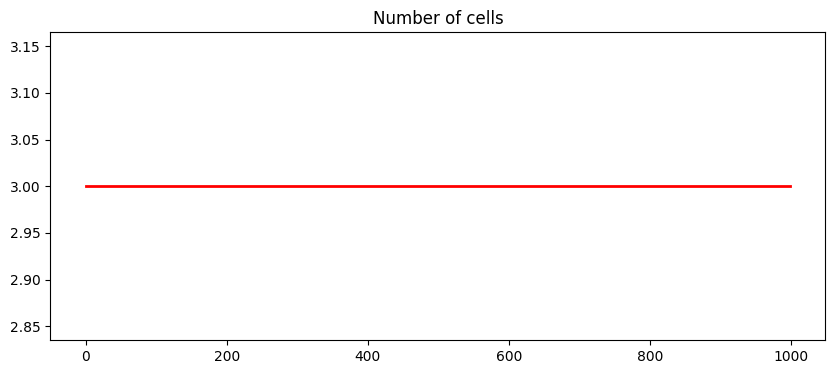

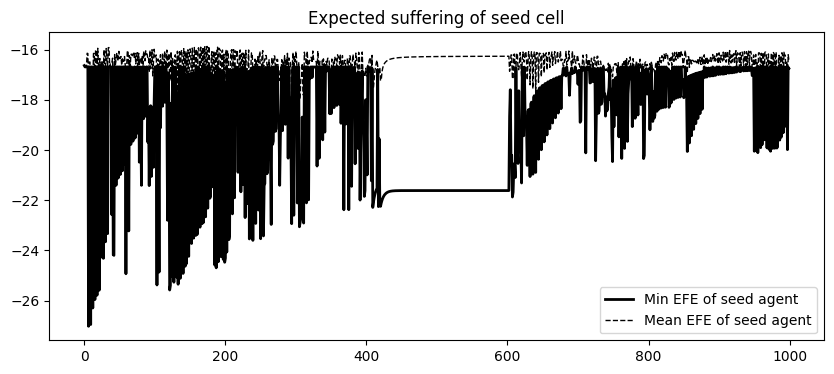

In [4]:
T = 1000

env = EnvironmentAgent(fn = lambda x, t: (t % 3 < 2) if (t < 200 or t > 800) else (t % 4 < 2 if (t < 400 or t > 600) else 1))
# env = EnvironmentAgent(fn = lambda x, t: (t % 3 < 2) if (t < 200 or t > 800) else (t % 4 < 2 if t < 400 or t > 600 else np.random.choice(a=[False, True])))
# env = EnvironmentAgent(fn = lambda x, t: t % 6 < 3)

all_agents = [env]
# TODO: Use_param_info_gain? Policy_len? Gamma? Save_belief_hist?
seed_cell = ConnectedAgent(penpals = [env], is_seed_cell = True)
all_agents.append(seed_cell)

def run_active_inference_loop(all_agents, env, T = T):
    # TODO: Make the initial observation fort the seed cell random
    # TODO: Allow multiple cells, not just the seed cell, to interact with the environment?
    for t in range(T):
        print(f"\n\n\nt = {t}")
        print("num_agents", len(all_agents))
        
        # Kill excess cells:
        if len(all_agents) > env.max_cells(t):
            sorted_by_efficacy = sorted(all_agents, key = lambda a: -a.self_efficacy())
            sorted_by_efficacy.remove(seed_cell) # For now don't allow the epithelial cell to be removed
            # TODO prevent the environment from being removed!
            # TODO: Change this ^ so internal cells become epithelial when necessary!
            excess_cells = sorted_by_efficacy[-len(all_agents) + env.max_cells(t):] # Keep only the most efficacious max_cell cells
            print(f"excess_cells {excess_cells}")
            for ec in excess_cells:
                print(f"max_cells: {env.max_cells(t)}, excess_cell: {ec} Removing")
                # The following works whereas a list iterator doesn't because we're removing items from the list as it operates
                while len(ec.penpals) > 0:
                    ec.bilateral_disconnect_from(ec.penpals[0])
                all_agents.remove(ec)
        # Perform autophagy on any orphaned cells which are only connected to themselves or to nobody
        internal_agents = [a for a in all_agents if a != seed_cell]
        while True:
            to_delete = [a for a in internal_agents if len(a.penpals) == 0 or a.penpals == [a]]
            if not to_delete:
                break
            for td in to_delete:
                print(f"Autophagy! {td}")
                if td.penpals:
                    td.bilateral_disconnect_from(td)
                internal_agents.remove(td)
                all_agents.remove(td)
        
        all_inputs = [a.compute_input() for a in all_agents]
        # Note it's important to copy all_agents since we're modifying all_agents along the way
        for agent, a_in in zip(copy.copy(all_agents), all_inputs):
            print(f"{agent} IWE {agent._interacts_with_environment()}, dim {len(agent.A[0])}, self-efficacy {agent.self_efficacy()}, input {a_in}")
            print(f"Self-efficacy in each channel {agent.self_efficacy(wrt = 'all')}")
            # bb = agent.binarize_B()
            qs = agent.infer_states([a_in]) # Note this assumes all observations are in obs[0]
            q_pi, efe = agent.infer_policies()
            # agent.unbinarize_B(bb)
            # TODO: Compute an "actual suffering" metric in addition to a predicted one?
            nailed_it_this_turn = max(agent.C[0]) == agent.C[0][a_in]
#             num_continuous_nails = 0
#             for i in range(len(nailed_it)): # Note this is only if the seed cell nailed it, not me!
#                 if nailed_it[-i]:
#                     num_continuous_nails += 1
#                 else:
#                     break
            if not nailed_it_this_turn:
                agent.stress = min(agent.stress + SELF_STRESS_INCREMENT, MAX_STRESS)
                for p in agent.penpals:
                    if p != agent:
                        p.stress = min(p.stress + (ALL_PENPAL_STRESS_INCREMENT / len(agent.penpals)), MAX_STRESS)
            print(f"Agent stress: {agent.stress}")

            agent.update_B()
            chosen_action_id = agent.sample_action()
            agent.update_C()
            
            #agent.stress = max(agent.stress - 1, MIN_STRESS)
            agent.stress = max(agent.stress * (1 - STRESS_RELIEF), MIN_STRESS)
            
            print(f"{agent} Received input: {a_in}")
            
            if not agent.__repr__() in self_efficacies:
                self_efficacies[agent.__repr__()] = {}
            self_efficacies[agent.__repr__()][t] = agent.self_efficacy()
            if not t in self_efficacies['all']:
                self_efficacies['all'][t] = agent.self_efficacy()
            else:
                self_efficacies['all'][t] += agent.self_efficacy()
            
            if not agent.__repr__() in stemnesses:
                stemnesses[agent.__repr__()] = {}
                stresses[agent.__repr__()] = {}
            stemnesses[agent.__repr__()][t] = agent.stemness()
            stresses[agent.__repr__()][t] = agent.stress
            if not t in stemnesses['avg']:
                stemnesses['avg'][t] = (agent.stemness() / len(all_agents))
                stresses['avg'][t] = (agent.stress / len(all_agents))
            else:
                stemnesses['avg'][t] += (agent.stemness() / len(all_agents))
                stresses['avg'][t] += (agent.stress / len(all_agents))
            
            for p in agent.penpals:
                print(f"\t{p}->{agent.message_from(a_in, p)}->{agent}")
            print(f"{agent} Sent output: {int(agent.action[0])}")
            if agent == seed_cell:
                msgs_from_env.append(agent.message_from(a_in, 'env'))
                self_msgs.append(agent.message_from(a_in, agent))
                mean_efes.append(np.mean(efe))
                min_efes.append(min(efe))
                num_cells.append(len(all_agents))
                # TODO: Consider having not just expected but actual FE?
                nailed_it.append(agent.message_from(a_in, 'env') == agent.message_from(a_in, agent))
                nailed_it_trailing.append(float(np.count_nonzero(nailed_it[-50:]) / len(nailed_it[-50:])))
            for p in agent.penpals:
                print(f"\t{agent}->{agent.message_for(p)}->{p}")
            print("\n")
            if agent.wants_to_divide() and len(all_agents) < env.max_cells(t):
                # TODO: Make sure it passes the right number to the environment!
                all_agents.append(agent.symmetric_divide()[1])
                assert(p in all_agents for p in agent.penpals)

msgs_from_env = []
self_msgs = []
min_efes = []
mean_efes = []
nailed_it = []
nailed_it_trailing = []
num_cells = []
self_efficacies = {'all': {}}
stemnesses = {'avg': {}}
stresses = {'avg': {}}
qs = run_active_inference_loop(all_agents, env)

plt.figure(figsize=(10,4))
plt.plot(msgs_from_env, linewidth = 1, label = "Message from environment")
plt.plot(self_msgs, linewidth = 1, label = "Self-message")
plt.title(f"Messages from environment and from seed cell for seed cell")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(nailed_it, linewidth = 0.25, label = "Seed cell sent itself same message as environment did?")
plt.plot(nailed_it_trailing, linewidth = 1, label = "Trailing 50 turns average %")
plt.plot([0, T], [0.5, 0.5], linewidth = 1, label = "Reference")
plt.title(f"Seed cell nailed it?")
plt.legend(loc = 4)
plt.show()

# plt.figure(figsize=(10,4))
# for ag_repr, sub_d in self_efficacies.items():
#     plt.plot(sub_d.keys(), sub_d.values(), linewidth = 1, label = ag_repr)
# plt.title(f"Self-efficacies")
# plt.legend()
# plt.show()

plt.figure(figsize=(10,4))
for ag_repr, sub_d in stresses.items():
    plt.plot(sub_d.keys(), sub_d.values(), linewidth = 1, label = ag_repr)
plt.title(f"Stresses")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
for ag_repr, sub_d in stemnesses.items():
    plt.plot(sub_d.keys(), sub_d.values(), linewidth = 1, label = ag_repr)
plt.title(f"Stemnesses")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(num_cells, linewidth = 2, color = 'r', label = "Number of cells")
plt.title(f"Number of cells")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(min_efes, linewidth = 2, color = 'k', label = "Min EFE of seed agent")
plt.plot(mean_efes, linewidth = 1, linestyle='dashed', color = 'k', label = "Mean EFE of seed agent")
plt.title(f"Expected suffering of seed cell")
plt.legend()
plt.show()

In [5]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.
